# Training an image classifier
Load and normalize the CIFAR10 training and test datasets using torchvision
Define a Convolutional Neural Network
Define a loss function
Train the network on the training data
Test the network on the test data

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
# Data Transformation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Batch size
batch_size = 4

# Training dataset and DataLoader
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

# Test dataset and DataLoader
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

# Class labels
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


100%|███████████████████████████████████████████████████████████████| 170498071/170498071 [01:23<00:00, 2043408.39it/s]


Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified


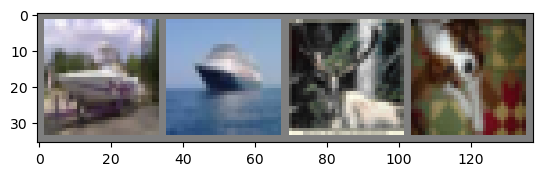

ship  ship  deer  dog  


In [3]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))

# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [4]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)  # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Create an instance of the network
net = Net()


In [5]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# Train The network

In [6]:

# Training loop
for epoch in range(2):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels.long())  # Convert labels to the appropriate data type
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:  # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')


[1,  2000] loss: 2.197
[1,  4000] loss: 1.824
[1,  6000] loss: 1.637
[1,  8000] loss: 1.571
[1, 10000] loss: 1.498
[1, 12000] loss: 1.460
[2,  2000] loss: 1.375
[2,  4000] loss: 1.355
[2,  6000] loss: 1.312
[2,  8000] loss: 1.303
[2, 10000] loss: 1.265
[2, 12000] loss: 1.249
Finished Training


In [7]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

# Test the network on the test data

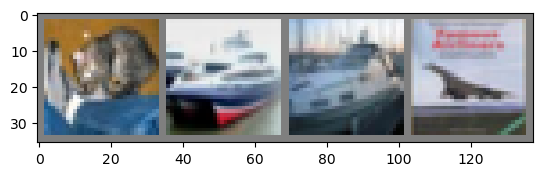

GroundTruth: cat   ship  ship  plane


In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have a function 'imshow' to display images. If not, you can use the following simple function:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get a batch of images from the testloader
dataiter = iter(testloader)
images, labels = next(dataiter)

# Display the images
imshow(torchvision.utils.make_grid(images))

# Print the ground truth labels
print('GroundTruth:', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))


In [9]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [10]:
outputs = net(images)

In [11]:
_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
 for j in range(4)))

Predicted:  cat   ship  car   ship 


In [12]:
correct = 0
total = 0

# since we're not training, we don't need to calculate the gradients for ou
with torch.no_grad():
    for data in testloader:
        images, labels = data

        # calculate outputs by running images through the network
        outputs = net(images)

        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct / total:.2f}%')


Accuracy of the network on the 10000 test images: 56.30%


In [13]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# no gradients needed during evaluation
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)

        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class {classname:5s}: {accuracy:.1f}%')


Accuracy for class plane: 64.7%
Accuracy for class car  : 78.2%
Accuracy for class bird : 41.2%
Accuracy for class cat  : 52.1%
Accuracy for class deer : 35.6%
Accuracy for class dog  : 35.5%
Accuracy for class frog : 70.4%
Accuracy for class horse: 59.5%
Accuracy for class ship : 65.6%
Accuracy for class truck: 60.2%
